### Probably Overkill Imports

In [1]:
# Imports
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

import pickle

# Import
# Math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
import random
from scipy.stats import norm
import scipy.optimize as optimize
import time
import math as m

# Ez parallelization
from joblib import Parallel, delayed

# File Handling
from sys import getsizeof
import _pickle as pickle
# Alternatively use JSON which will be human readable
# import json

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Custom imports
from MarketGeneratingFunctions.global_cache import Global_Cache
import MarketGeneratingFunctions.base_from_gen as bg
import MarketGeneratingFunctions.pricing_func as pf
from MarketGeneratingFunctions.path_datatype import Path

c:\Users\osc16\miniconda3\envs\d2d\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Load a test dataset (In this case all runs with idx over 800 (where train maxes) :/)

In [2]:
## Load File
with open("0.7CorrTest.pkl","rb") as fp:
    paths = pickle.load(fp)

### Setup tests just like when testing delta hedge

#### Base Cases

In [3]:
### Unhedged PnL
def pnl_cva(path):
    pnl_without_hedge = np.zeros(len(path.CVA)-1)
    for i in range(1, len(path.CVA)):
        pnl_without_hedge[i-1] = path.CVA[i]-path.CVA[i-1]
    return pnl_without_hedge

pnl_without_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_without_hedge[i] = pnl_cva(paths[i])

### Delta Hedged PnL
if not 'T_s' in vars() or 'T_s' in globals():
    T_s = np.arange(0,21)
from MarketGeneratingFunctions import DeltaHedge
def DeltaFromFunc(path):
    pnl = np.zeros(len(path.CVA)-1)
    for i in range(len(path.CVA)-1):
        t = path.t_s[i]
        Q = [1] + [path.Q_s[j][i] for j in range(1,21)]
        Swapts = [0.0] + [path.Swaptions[j][i] for j in range(0,19)]
        T_sl = T_s.copy()
        
        [SwapsHedge,Qhedge] = DeltaHedge.delta_hedge(Swapts,Q,T_sl,t)

        cost = np.inner(SwapsHedge,Swapts) + np.inner(Qhedge,Q)
        
        futureSwapts = [0] + [path.Swaptions[j][i+1] for j in range(0,19)]
        futureQ = [path.Q_s[j][i+1] for j in range(0,21)]
        value = np.inner(SwapsHedge,futureSwapts) + np.inner(Qhedge,futureQ)
        #print(np.concat([SwapsHedge,Qhedge]))

        pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))
    return pnl

pnl_delta_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_delta_hedge[i] = DeltaFromFunc(paths[i])


#### RL Hedge

In [6]:
import AutoEncoder
import pickle
import torch as th
#with open("autoencoderT","rb") as fp:
#    encoder = pickle.load(fp)

modelG = PPO.load("best_model07SoFar10.zip")
#modelR = PPO.load("dqn_lunar")
action_scale = 10

def rlHedge(path, model):
    pnl = np.zeros(len(path.CVA)-1)
    for i in range(round((len(path.CVA)-1))):
        # Get State
        lambdax = np.tanh(np.log((path.lambdas[i] - 0.001)+1)) if path.lambdas[i] != -0.999 else -1
        r = np.tanh(path.r[i]) 
        t = path.t_s[i]/10 - 1

        Q = [path.Q_s[j][i] for j in range(1,21)]
        Swapts = [0.0] + [path.Swaptions[j][i] for j in range(0,19)]

        futureQ = [path.Q_s[j][i+1] for j in range(1,21)]
        futureSwapts = [0.0] + [path.Swaptions[j][i+1] for j in range(0,19)]

        # Create Hedge
        # Auto Enconder : hedgPos = model.predict(encoder.encoder(th.from_numpy(encoder.preprocess(np.concat([Swapts,Q])))).detach().numpy(), deterministic = True)
        hedgPos = model.predict(np.asmatrix([lambdax,r,t]), deterministic = True)
        hedgPos = hedgPos[0][0]
        #print(hedgPos)

        if len(hedgPos) == 2:
            swpt = hedgPos[0]
            Qq = hedgPos[1]
            hedgPos = np.concatenate([np.zeros(19), [swpt], np.zeros(19), [Qq]])*action_scale
        if len(hedgPos) == 41:
            [SwapsHedge,Qhedge] = DeltaHedge.delta_hedge(Swapts,[1] + Q,np.arange(0,21),t)
            SwapsHedge = [SwapsHedge[i]*(hedgPos[40] + 1) + hedgPos[i]*0.2 for i in range(0,20)]
            Qhedge = [Qhedge[i-20]*(hedgPos[40] + 1) + hedgPos[i]*0.2 for i in range(20,40)]
            hedgPos = np.concatenate([SwapsHedge,Qhedge])
        swpPos = hedgPos[0:20]
        QPos = hedgPos[20:]

        cost = np.sum(np.inner(swpPos,Swapts) + np.inner(QPos,Q))
        value = np.sum(np.inner(swpPos,futureSwapts) + np.inner(QPos,futureQ))

        pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))
    return pnl

pnl_RL_hedge = [None]*(len(paths)-90)
pnl_RL_hedgeb = [None]*len(paths)

for i in range(len(pnl_without_hedge)-90):
    pnl_RL_hedge[i] = rlHedge(paths[i], modelG)
    #pnl_RL_hedgeb[i] = rlHedge(paths[i], modelR)            


(-0.0005, 0.0005)

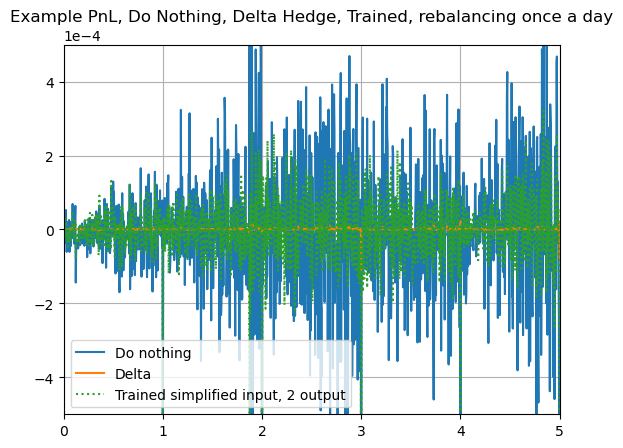

In [10]:
plt.figure(1)
plt.title("Example PnL, Do Nothing, Delta Hedge, Trained, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(paths[49].t_s[1:],pnl_without_hedge[0])
plt.plot(paths[49].t_s[1:],pnl_delta_hedge[0])
plt.plot(paths[49].t_s[1:],pnl_RL_hedge[0], linestyle = ':')
#plt.plot(paths[0].t_s[1:],pnl_RL_hedgeb[0], linestyle = ':')
plt.legend(['Do nothing','Delta','Trained simplified input, 2 output','Untrained'])
plt.xlim((0,5))
plt.ylim((-5*1e-4,5*1e-4))

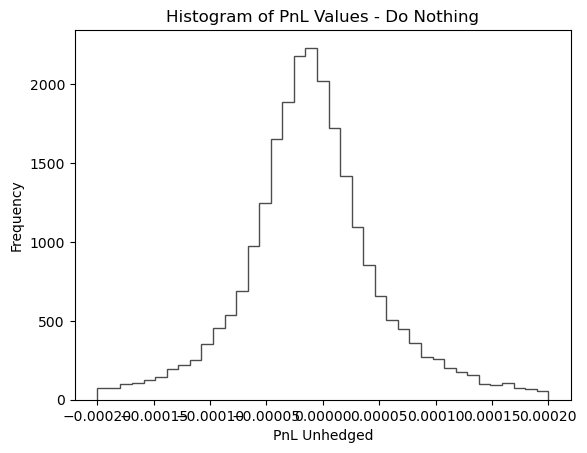

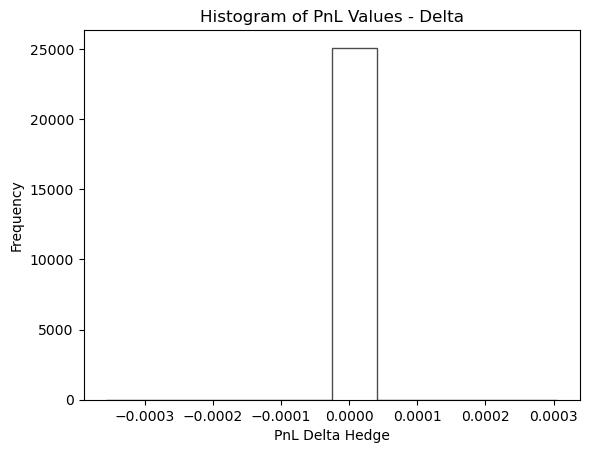

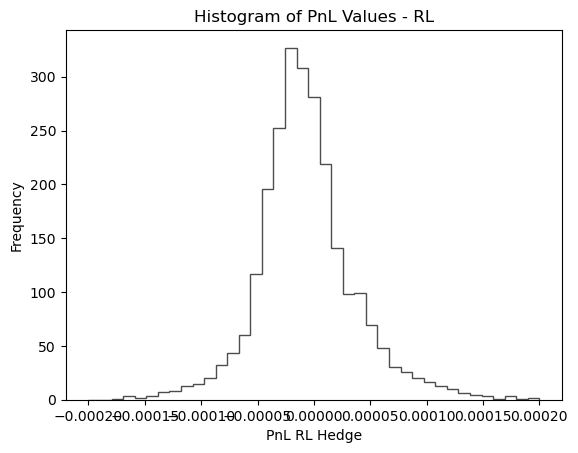

In [8]:
plt.hist([float(a) for b in pnl_without_hedge for a in b[0:251]], histtype='step', bins=np.linspace(-2e-4,2e-4,40), edgecolor='black', alpha=0.7)
plt.xlabel("PnL Unhedged")
plt.ylabel("Frequency")
#plt.xlim(-2*1e-4, 0.0) #min(worst_5_percent_values)*2
plt.title("Histogram of PnL Values - Do Nothing")
plt.show()
plt.hist([float(a) for b in pnl_delta_hedge for a in b[0:251]], histtype='step',  edgecolor='black', alpha=0.7, color='black')
plt.xlabel("PnL Delta Hedge")
plt.ylabel("Frequency")
#plt.xlim(-2*1e-4, 0.0) #min(worst_5_percent_values)*2
plt.title("Histogram of PnL Values - Delta")
plt.show()
plt.hist([float(a) for b in pnl_RL_hedge for a in b[0:251]], histtype='step', bins=np.linspace(-2e-4,2e-4,40), edgecolor='black', alpha=0.7)
plt.xlabel("PnL RL Hedge")
plt.ylabel("Frequency")
#plt.xlim(-2*1e-4, 0.0) #min(worst_5_percent_values)*2
plt.title("Histogram of PnL Values - RL")
plt.show()

In [ ]:
score = lambda pnls: np.sum(np.pow(pnls[0:251],2))
print(score(pnl_without_hedge))
print(score(pnl_delta_hedge))
print(score(pnl_RL_hedge))

score = lambda pnls: np.sum(np.abs(pnls[0:251]))
print(score(pnl_without_hedge))
print(score(pnl_delta_hedge))
print(score(pnl_RL_hedge))

0.011311107529756732
3.013232414388017e-06
0.012754237244233775
14.585655867181433
0.10349474484849179
0.016826456956926788


In [53]:
print(np.sum(np.abs(pnl_RL_hedge[5][0:251])))

0.00970537516084427
